In [54]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

from collections import defaultdict
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# Data preparation

In [55]:
df = pd.read_csv('air_dataset.csv')
df.drop(columns='Unnamed: 0',inplace=True)
class_name = 'weekend'

In [56]:
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [57]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [58]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [59]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,PT08_feat,weekend
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,1186.50,0
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,1148.75,0
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,1024.50,0
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,1015.00,0
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,883.25,0


# Data partitioning

In [60]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score

In [61]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100,stratify = y)

# Decisioin tree

In [62]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7035256410256411
Precision 0.48473967684021546
Recall 0.5018587360594795
F1-score [0.79048698 0.49315068]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1334
           1       0.48      0.50      0.49       538

    accuracy                           0.70      1872
   macro avg       0.64      0.64      0.64      1872
weighted avg       0.71      0.70      0.71      1872



### Gridsearch

In [63]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [83]:
parameters = {'min_samples_leaf': np.arange(1, 10 + 1),'criterion':['gini','entropy'],'min_samples_split':np.arange(2,10)}

dt = DecisionTreeClassifier()
search = GridSearchCV(dt, parameters,cv = 4)
search.fit(X_train, y_train)
report(search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.726 (std: 0.009)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 10, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.725 (std: 0.009)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 10, 'min_samples_split': 8}

Model with rank: 3
Mean validation score: 0.725 (std: 0.014)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}



In [84]:
clf = search.best_estimator_
clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [85]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7077991452991453
Precision 0.4909456740442656
Recall 0.45353159851301117


TypeError: 'numpy.ndarray' object is not callable

In [86]:
accuracy = cross_val_score(clf, X, y, cv=5)
print('Accuracy:', np.mean(accuracy),accuracy)
print()
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
print('Precision:', np.mean(precision), precision)
print()
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print('Recall:', np.mean(recall),recall)
print()
f1_score = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
print('F1-score:', np.mean(f1_score),f1_score)

Accuracy: 0.6712610834738039 [0.63675214 0.71581197 0.67664351 0.64831641 0.6787814 ]

Precision: 0.5208220991985895 [0.51889169 0.48730964 0.5127551  0.55182073 0.53333333]

Recall: 0.45813953488372094 [0.4744186  0.44186047 0.46976744 0.46046512 0.44418605]

F1-score: 0.5811741079573943 [0.56213483 0.61955615 0.6006601  0.54535164 0.57816783]


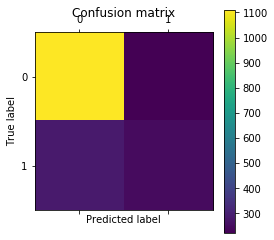

In [87]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROC curve

In [88]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc

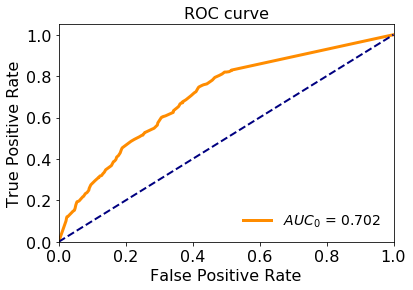

In [89]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

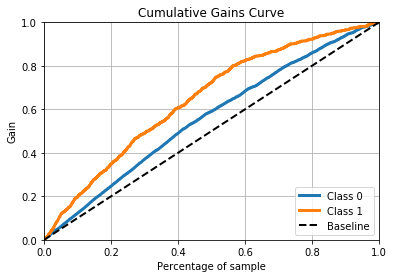

In [90]:
predicted_probas = clf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

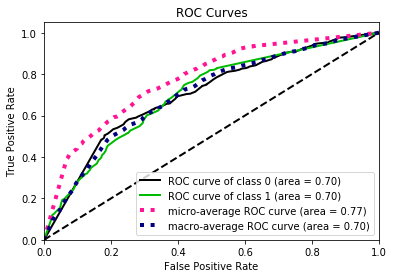

In [91]:
plot_roc(y_test, y_score)
plt.show()

# Lift chart

In [92]:
from scikitplot.metrics import plot_lift_curve

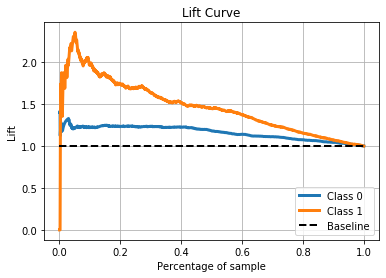

In [93]:
plot_lift_curve(y_test, y_score)
plt.show()